In [6]:
import os
import sys
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from PIL import Image, ImageStat

sys.path.append('..')
import datasets
from fathomnethelper.json_loader import Taxonomicon

In [83]:
with open('classes', "r") as f:
    classes = json.load(f)
num_classes = len(classes) + 1

train_dataset, test_dataset = datasets.load_datasets('FathomNet', root='data', classes=classes,
                                                         train_ratio=0.9)

colour_mappings = {}
colour_mappings.update({clss: 'tab:blue' for clss in ('Strongylocentrotidae','Pourtalesiidae')})
colour_mappings.update({clss: 'tab:orange' for clss in ('Elpidiidae','Psolidae','Laetmogonidae','Synallactidae','Cucumariidae')})
colour_mappings.update({clss: 'tab:red' for clss in ('Isididae','Plexauridae','Paragorgiidae','Alcyoniidae','Nephtheidae','Primnoidae')})
colour_mappings.update({clss: 'tab:green' for clss in ('Asteriidae','Solasteridae','Pterasteridae','Goniasteridae')})  
colour_mappings.update({clss: 'tab:purple' for clss in ('Funiculinidae','Umbellulidae')})  
colour_mappings.update({clss: 'tab:brown' for clss in ('Metridiidae','Actinernidae','Liponematidae','Actiniidae','Hormathiidae')})  
colour_mappings.update({clss: 'tab:pink' for clss in ('Farreidae','Rossellidae','Cladorhizidae','Hyalonematidae')})  
colour_mappings.update({clss: 'tab:gray' for clss in ('Antedonidae','Ophiacanthidae')}) 

### First, we read bounding box data

In [152]:
ann_paths = os.listdir(os.path.join('..', 'data', 'annotations'))
tax = Taxonomicon()
subtrees_of_each_class = {concept: set(tax.get_subtree_nodes(concept)) for concept in classes}
class_mapping = {}
for clss in classes:
    for val in subtrees_of_each_class[clss]:
        class_mapping[val] = clss

annotations = {concept: [] for concept in classes}

for ann in ann_paths:
    ann_tree = ET.parse(os.path.join('..', 'data', 'annotations', ann))
    tree_root = ann_tree.getroot()
    for box in tree_root.iter('object'):
        name = box.find('name').text
        if name in class_mapping:
            clss = class_mapping[name]
            xmin = int(box.find('bndbox/xmin').text)
            ymin = int(box.find('bndbox/ymin').text)
            xmax = int(box.find('bndbox/xmax').text)
            ymax = int(box.find('bndbox/ymax').text)
            annotations[clss].append((os.path.splitext(ann)[0] + '.png', (xmin, ymin, xmax, ymax)))

### Here we plot histograms of aspect ratios of each class

In [181]:
aspect_ratios = {
    clss: [(xmax-xmin)/(ymax-ymin) 
                   for (impath, (xmin,ymin,xmax,ymax)) in annotations[clss]] 
    for clss in classes
}

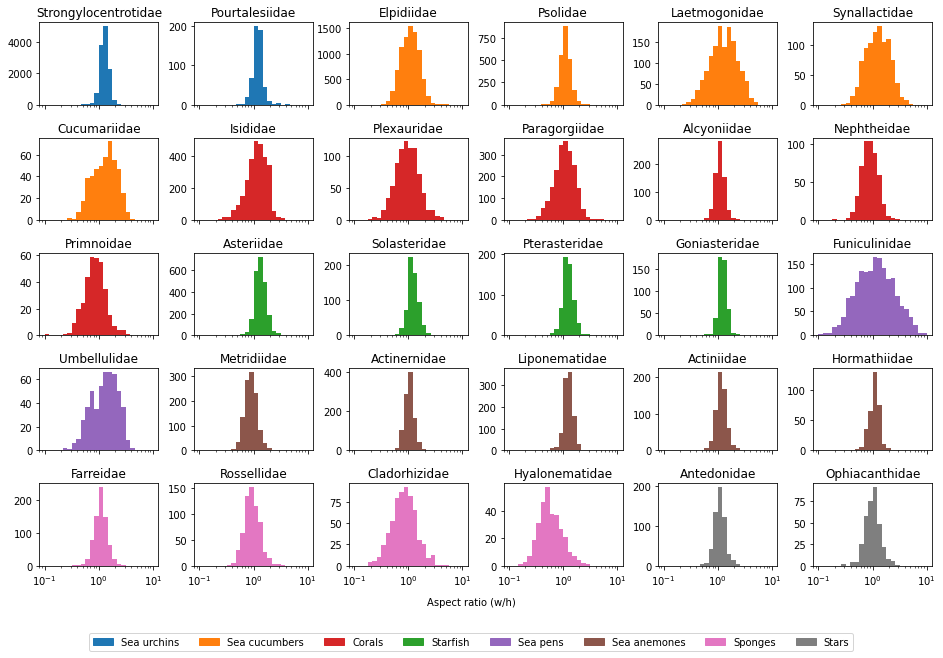

In [236]:
fig, axes = plt.subplots(ncols=6, nrows=5, figsize=(16,10), sharex=True)

logbins = np.geomspace(0.1, 10, 25)

for i in range(30):
    ax = axes[i//6][i%6]
    ax.set_title(labels_reordered[i])
    ax.hist(aspect_ratios[labels_reordered[i]], bins=logbins, color=colour_mappings[labels_reordered[i]])
    ax.set_xscale('log')


handles = [mpatches.Patch(color='tab:blue', label='Sea urchins'),
           mpatches.Patch(color='tab:orange', label='Sea cucumbers'),
           mpatches.Patch(color='tab:red', label='Corals'),
           mpatches.Patch(color='tab:green', label='Starfish'),
           mpatches.Patch(color='tab:purple', label='Sea pens'),
           mpatches.Patch(color='tab:brown', label='Sea anemones'),
           mpatches.Patch(color='tab:pink', label='Sponges'),
           mpatches.Patch(color='tab:gray', label='Stars')
]
plt.subplots_adjust(wspace=.3, hspace=.4)
plt.legend(bbox_to_anchor=(0.5,0), loc="lower center", 
                bbox_transform=fig.transFigure, ncol=8, handles=handles)

fig.text(0.5, 0.07, 'Aspect ratio (w/h)', ha='center')
plt.savefig('bounding_box_ratios.png', facecolor='white', transparent=False, dpi=200)

### Brightness histograms

In [178]:
import pickle
if os.path.exists(os.path.join('..', 'HPC', 'results', 'saved_brightnesses.pickle')):
    with open(os.path.join('..', 'HPC', 'results', 'saved_brightnesses.pickle'), 'rb') as f:
        brightness = pickle.load(f)
else:
    brightness = {clss: [] for clss in classes}
    for clss in classes:
        for im_name, box in annotations[clss]:
            im = Image.open(os.path.join('..','data','images', im_name)).convert('L').crop(box)
            stat = ImageStat.Stat(im)
            brightness[clss].append(stat.mean[0])
        

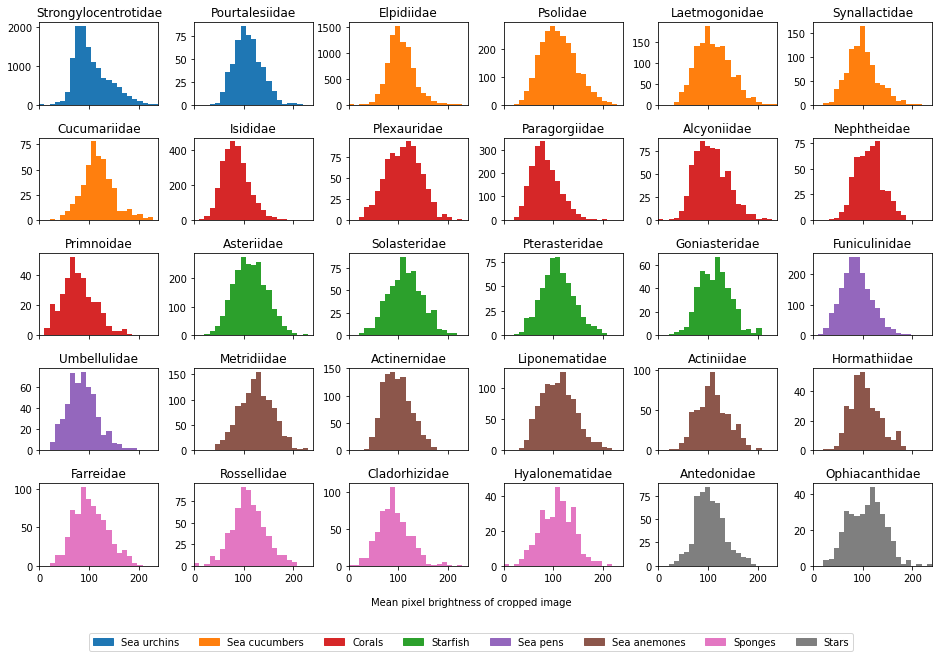

In [237]:
fig, axes = plt.subplots(ncols=6, nrows=5, figsize=(16,10), sharex=True)

bins = np.linspace(0, 250, 25)

for i in range(30):
    ax = axes[i//6][i%6]
    ax.set_title(labels_reordered[i])
    ax.hist(brightness[labels_reordered[i]], bins=bins, color=colour_mappings[labels_reordered[i]])
    ax.set_xlim(0,240)
    #ax.set_xscale('log')


handles = [mpatches.Patch(color='tab:blue', label='Sea urchins'),
           mpatches.Patch(color='tab:orange', label='Sea cucumbers'),
           mpatches.Patch(color='tab:red', label='Corals'),
           mpatches.Patch(color='tab:green', label='Starfish'),
           mpatches.Patch(color='tab:purple', label='Sea pens'),
           mpatches.Patch(color='tab:brown', label='Sea anemones'),
           mpatches.Patch(color='tab:pink', label='Sponges'),
           mpatches.Patch(color='tab:gray', label='Stars')
]
plt.subplots_adjust(wspace=.3, hspace=.4)
plt.legend(bbox_to_anchor=(0.5,0), loc="lower center", 
                bbox_transform=fig.transFigure, ncol=8, handles=handles)
fig.text(0.5, 0.07, 'Mean pixel brightness of cropped image', ha='center')
plt.savefig('brightness.png', facecolor='white', transparent=False, dpi=200)
        

### Area histograms

In [217]:
areas = {
    clss: [(xmax-xmin)*(ymax-ymin) 
                   for (impath, (xmin,ymin,xmax,ymax)) in annotations[clss]] 
    for clss in classes
}

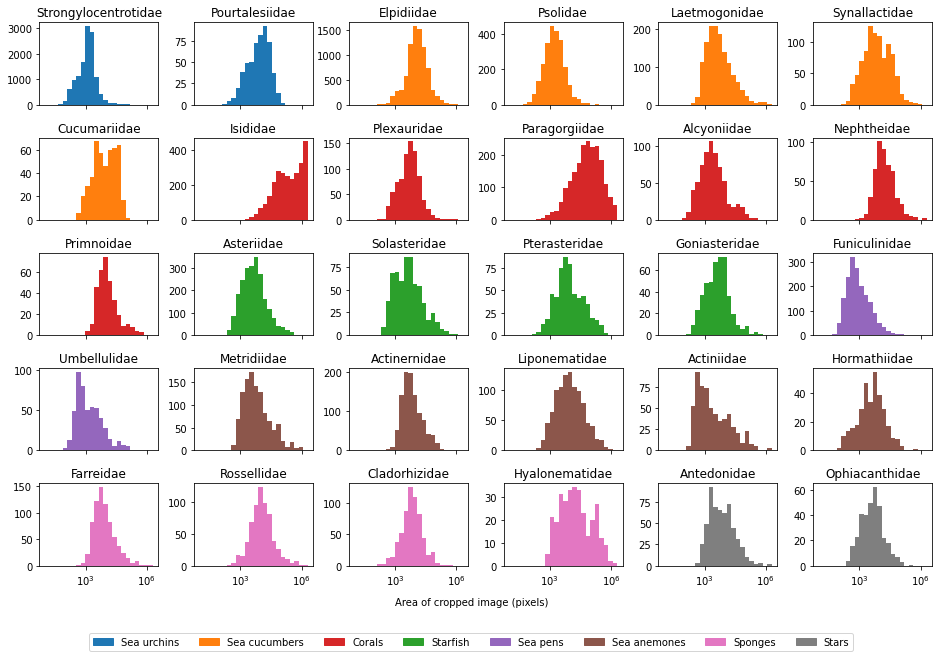

In [231]:
fig, axes = plt.subplots(ncols=6, nrows=5, figsize=(16,10), sharex=True)

logbins = np.geomspace(10, 2000000, 25)

for i in range(30):
    ax = axes[i//6][i%6]
    ax.set_title(labels_reordered[i])
    ax.hist(areas[labels_reordered[i]], bins=logbins, color=colour_mappings[labels_reordered[i]])
    ax.set_xscale('log')
    #ax.set_yscale('log')


handles = [mpatches.Patch(color='tab:blue', label='Sea urchins'),
           mpatches.Patch(color='tab:orange', label='Sea cucumbers'),
           mpatches.Patch(color='tab:red', label='Corals'),
           mpatches.Patch(color='tab:green', label='Starfish'),
           mpatches.Patch(color='tab:purple', label='Sea pens'),
           mpatches.Patch(color='tab:brown', label='Sea anemones'),
           mpatches.Patch(color='tab:pink', label='Sponges'),
           mpatches.Patch(color='tab:gray', label='Stars')
]
plt.subplots_adjust(wspace=.3, hspace=.4)
plt.legend(bbox_to_anchor=(0.5,0), loc="lower center", 
                bbox_transform=fig.transFigure, ncol=8, handles=handles)

fig.text(0.5, 0.07, 'Area of cropped image (pixels)', ha='center')
plt.savefig('area.png', facecolor='white', transparent=False)